# Homework 1

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

* Do a grid convergence study to test the accuracy of your method.
* Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.


In [68]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

# functions: cosspace, vander_chebyshev, chebeval
# class: exact_tanh
%run chebyshev_support.py

## Solving the ODE: Discussion

We're looking to create a linear system that looks like the one below to discretize the IVP.

$$L\mathbf{u} = \mathbf{f}$$

Suppose we're looking at $n$ points. $\mathbf{u}$ and $\mathbf{f}$ , each vectors of length $n$ will represent the values of the $u_i$ functions and right-hand side functions at those points.

The $L$ matrix reflects the left hand side of the differential equation, $u''(t) + a u'(t) + b u(t)$. Define $T$ as an $n\times n$ Vandermonde matrix where terms evaluate the $n$-term Chebychev polynomial at our $n$ points; $T'$ and $T''$ do the same with the first and second derivatives of the polynomial, respectively. Note that to create Chebyshev polynomials for our time interval $t \in [0,1]$, we must adjust to $x \in [-1, 1]$ ($x = 2t - 1$). Begin constructing the $L$ matrix with the following:

$$L_{WIP} = T'' + aT' + bT$$

Next, we apply initial conditions to the system. We'll use the first and last rows of the matrices, which currently correspond to values of $u$ at $t=0$ and $t=1$, where the differential equation isn't actually defined.

For the initial condition $u(0) = 1$, replace, replace the first row of $L_{WIP}$ with the first row of $T$ and set the first element in $f$ to $1$. For $u'(0) = 0$, replace, replace the last row of $L_{WIP}$ with the last row of $T'$ and set the last element in $f$ to $0$.

Finally, post-multiply the modified $L_{WIP}$ by $T^{-1}$, to interpolate from the point vectors we apply the resulting $L$ matrix to.

(For somewhat more detail on constructing $L$ and $f$ for a boundary value problem, see [this notebook](../notes/chebyshev-bvp.ipynb), which follows the lecture example).

## Solving the ODE: Code

Below is a Python implementation of the solution approach described above.

In [69]:
def hw_cheb(n, rhsfunc, u_iv, du_iv, a = 1, b = 1):
    """
    Solve the following initial value problem on [0, 1] using n elements with 
    rhsfunc(x) forcing.
    
    u''(t) + au(t) + bu(t) = f(t)
    
    u_iv specifies the initial condition u(0) = u_iv
    du_iv specifies the initial condition u'(0) = du_iv
    """
    t = cosspace(0, 1, n+1)
    
    # T[0]: chebychev expansion evaluated at points in x
    # T[1]: first derivative of chebychev expansion evaluated at points in x
    # T[2]: second derivative of chebychev expansion evaluated at points in x
    T = chebeval(2 * t - 1)
    
    # Carry the variable substitution through the derivative. (dx/dt = 2)
    T[1] *= 2 
    T[2] *= 4
    
    # L will be our left hand side, starting out with u'' + au' + bu
    L = T[2] + a * T[1] + b * T[0]
    
    # Our right hand side begins with the forcing function f(x)
    rhs = numpy.array([rhsfunc(t)]).T
    
    # Now we'll apply the initial conditions to the first and last rows of L
    L[0] = T[0][0]  
    rhs[0] = u_iv
    L[-1] = T[1][0]  
    rhs[-1] = du_iv
    
    # Our final left hand side operator includes applying T^-1; when it's 
    # applied to a vector of function points, we get back the coefficients of 
    # the interpolating polynomial for that function (these are used with L to 
    # evaluate that function's derivatives and the boundary conditions).
    return t, L.dot(numpy.linalg.inv(T[0])), rhs


To test it, we'll use the exact solution for the case $a = 2$, $b = 1$, $f(t) = 0$:  
$$u(t) = e^{-t}(t + 1)$$

<IPython.core.display.Javascript object>


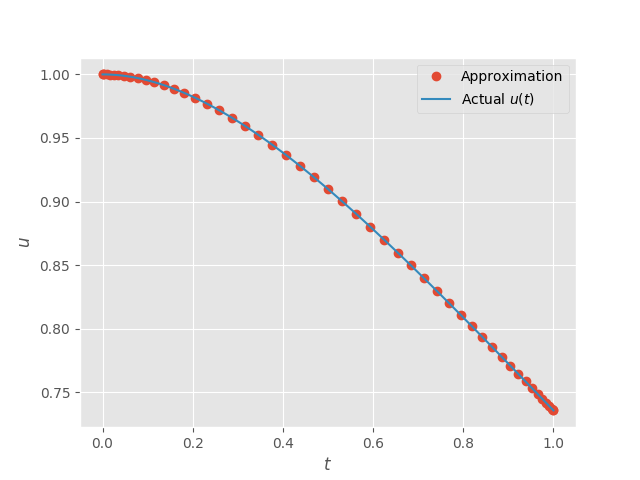

In [70]:
a = 2
b = 1
u = lambda t: numpy.exp(-t) * (t + 1) 
du = lambda t: -1 * numpy.exp(-t) * t 
ddu = lambda t: numpy.exp(-t) * (t - 1) 

pyplot.figure()

# Calculate and plot the approximate solution
n = 50
t, M, rhs = hw_cheb(n, lambda t: numpy.zeros_like(t), 1, 0, a = a, b = b)
u_points = numpy.linalg.solve(M, rhs)
pyplot.plot(t, u_points, 'o', label='Approximation')

# Plot the exact solution
tt = numpy.linspace(0, 1, 100)
pyplot.plot(tt, u(tt), label='Actual $u(t)$');
pyplot.xlabel('$t$')
pyplot.ylabel('$u$')
pyplot.legend(loc='upper right');

## Convergence Study

For the convergence study, we'll use the familiar solution $u(t) = \tanh(t)$.

<IPython.core.display.Javascript object>


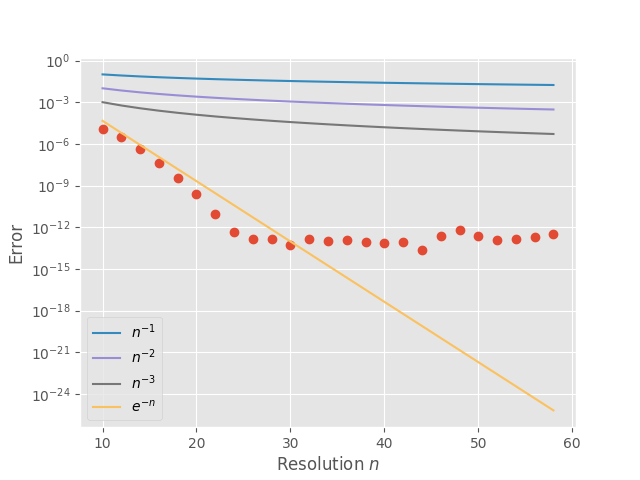

In [76]:
def convergence_study(grids, u, du, ddu, a, b):
    error = []
    rhs_fnc = lambda t: ddu(t) + a * du(t) + b * u(t)
        
    for n in grids:
        # Calculate the approximate solution
        
        t, L, rhs = hw_cheb(n, rhs_fnc, u(0), du(0), a = a, b = b)
        
        approx_points = numpy.linalg.solve(L, rhs)
        
        # Record the error between the approximation and the actual solution
        actual_points = numpy.array([u(t)]).T
        error.append(numpy.linalg.norm(
            approx_points[1:-2] - actual_points[1:-2], 
            numpy.inf))
    return grids, error

a = 1
b = 1
soln = exact_tanh(2, .3)
grids = numpy.arange(10, 60, 2)
ns, error = convergence_study(grids, soln.u, soln.du, soln.ddu, a, b)

# Start a new figure and plot the error against comparison lines
pyplot.figure()
pyplot.semilogy(ns, error, 'o')
for i in range(1, 4):
    pyplot.semilogy(grids, grids ** (-1.0 * i), label="$n^{{-{:d}}}$".format(i))

pyplot.semilogy(grids, numpy.exp(-grids), label="$e^{{-n}}$".format(i))
pyplot.xlabel('Resolution $n$')
pyplot.ylabel('Error')
pyplot.legend(loc='lower left')

Here, we see the method converge exponentially through $n \approx 28$. The error generally increases, albeit slowly, for higher $n$.

## Experiments with $a$ and $b$

According to the internet, and verified by an old Diff Eq book, this IVP describes a harmonic oscillator; with $f(t) = 0$, the sytem is undriven.

The code below shows a plot comparing results for different $a$ values with a fixed $b$ value.

<IPython.core.display.Javascript object>


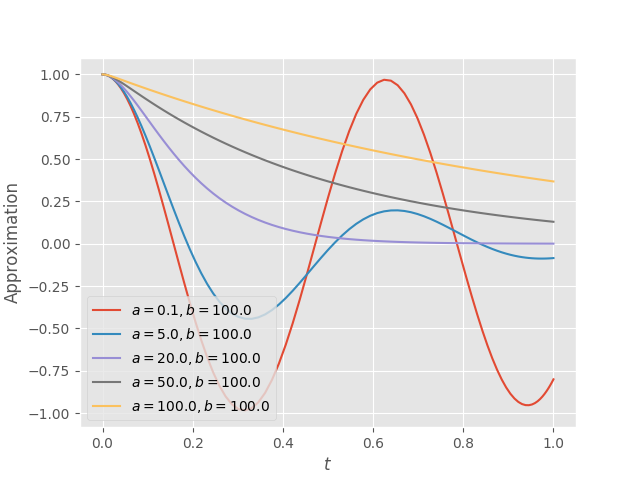

In [75]:
def temp_plot(a, b, n = 100):
    rhs_func = lambda t: numpy.zeros_like(t)
    t, M, rhs = hw_cheb(n, rhs_func, u_iv = 1, du_iv = 0, a = a, b = b)

    # Calculate and plot the approximate solution
    u_points = numpy.linalg.solve(M, rhs)
    pyplot.plot(t, u_points, '-', 
                label="$a = {:0.1f}, b = {:.1f}$".format(a, b))

pyplot.figure()
temp_plot(0.1, 100)
temp_plot(5, 100)
temp_plot(20, 100)
temp_plot(50, 100)
temp_plot(100, 100)

pyplot.xlabel('$t$')
pyplot.ylabel('Approximation')
pyplot.legend(loc='lower left')

Given a $b$ value, the value of $a$ causing "critical damping" is $2\sqrt{b}$; this is seen in the $a=20$ example. $a$ values below this produce an underdamped system, which osciallates; above this value, the system is overdamped and decays.

Below is another plot comparing different $b$ values for a single $a$ value.

<IPython.core.display.Javascript object>


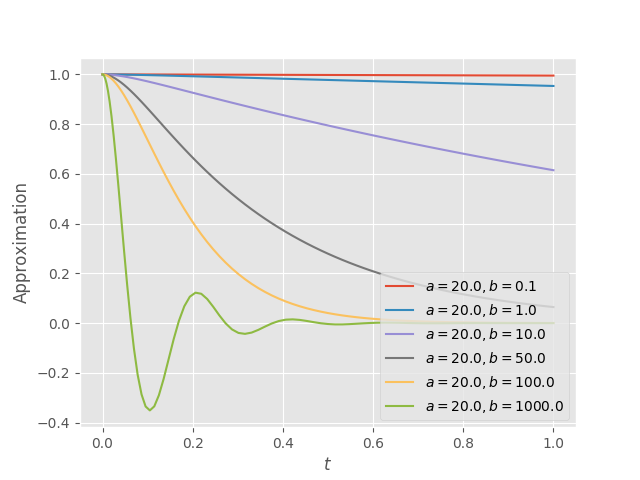

In [73]:
pyplot.figure()
temp_plot(20, 0.1)
temp_plot(20, 1)
temp_plot(20, 10)
temp_plot(20, 50)
temp_plot(20, 100)
temp_plot(20, 1000)

pyplot.xlabel('$t$')
pyplot.ylabel('Approximation')
pyplot.legend(loc='lower right')